In [213]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix,auc,roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.neighbors import LocalOutlierFactor

In [214]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [215]:
#Load Data
df = pd.read_csv("../data/creditcard.csv")

In [229]:
def get_hour_rate(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<=3600*(hours+1)]
    anomalies = _[_["Class"]==1]
    con_rate = anomalies.shape[0]/_.shape[0]
    return con_rate

In [230]:
rate = []
for i in range(48):
    rate.append(get_hour_rate(df, i))

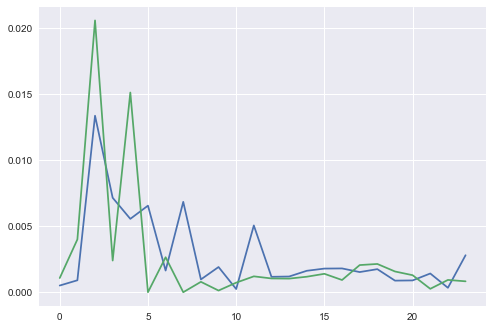

In [231]:
plt.plot(rate[:24])
plt.plot(rate[24:48])

In [234]:
m_rate = [(rate[:24][i] + rate[24:48][i])/2 for i in range(24)]

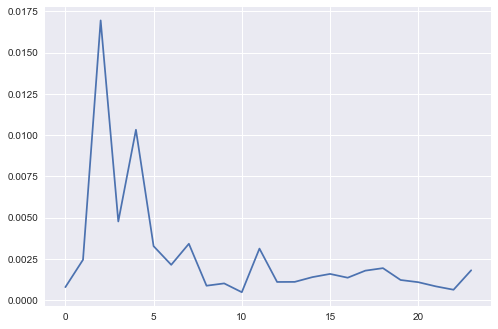

In [235]:
plt.plot(m_rate)

In [236]:
def get_hour_anomaly(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    anomalies = _[_["Class"]==1]
    return anomalies.shape[0]
anomaly = []
for i in range(48):
    anomaly.append(get_hour_anomaly(df, i))

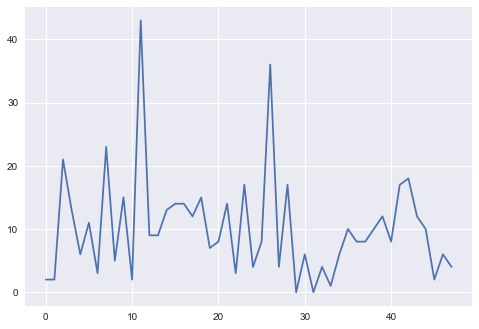

In [237]:
plt.plot(anomaly)

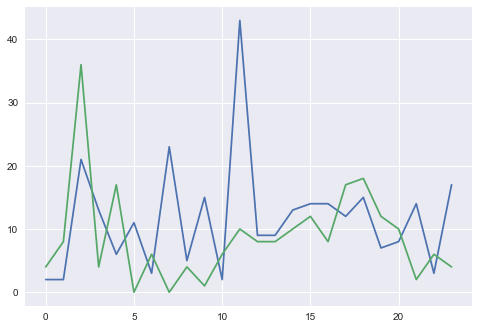

In [238]:
plt.plot(anomaly[:24])
plt.plot(anomaly[24:48])

We get hour data to calculate

In [239]:
def get_hour_df(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    return _

In [300]:
def get_hour_data(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    _["Amount"] = _["Amount"]
    _["Time"] = _["Time"]
    X = _.drop(columns = ['Class']).to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

For Local Outlier Factor we have 3 essential component for the input:
    
    1. the algorithm for finding nearestneighbors of a point
    2. the formula for distance calculation, which then transformed into Factor score
    3. the contamination rate which determine the cut off factor score series

In [301]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor = []
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=20, 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=0.0017*5)
    X, y = get_hour_data(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor.append(clf.negative_outlier_factor_)
    
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[143277   1187]
 [   225     56]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    143502
         1.0       0.20      0.05      0.07      1243

    accuracy                           0.99    144745
   macro avg       0.60      0.52      0.53    144745
weighted avg       0.98      0.99      0.99    144745



# Analysis & Optimization

So the first problem with LocalOutlierFactor is the calculation of distance consider all Variable being equal (for the distance). 

Time and Amount is not normalized variable (the other one are obtained through PCA and seems to have gone through some normalization already so we will not try to change it).

In [302]:
def get_hour_data(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    _["Amount"] = _["Amount"]/20
    _["Time"] = _["Time"]/72
    X = _.drop(columns = ['Class']).to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor = []
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=20, 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=0.0017*5)
    X, y = get_hour_data(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor.append(clf.negative_outlier_factor_)
    
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[143348   1116]
 [   154    127]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    143502
         1.0       0.45      0.10      0.17      1243

    accuracy                           0.99    144745
   macro avg       0.72      0.55      0.58    144745
weighted avg       0.99      0.99      0.99    144745



We use our pseudo m_rate for hourly rate since our dataset is limited, but its use-case is realistic with more available data in real life

In [303]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor = []
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=20, 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=m_rate[i]*5)
    X, y = get_hour_data(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor.append(clf.negative_outlier_factor_)
    
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[143362   1102]
 [   146    135]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    143508
         1.0       0.48      0.11      0.18      1237

    accuracy                           0.99    144745
   macro avg       0.74      0.55      0.59    144745
weighted avg       0.99      0.99      0.99    144745



By projecting F factor and V17 together we can have some insight about how the algorithm perform badly:
    
    The distance calculations takes all dimension equally, which lead to many noises, 
    false negative: Low F score
    false positive: unexpected high F score may come from some anomaly in variable such as Amount which can cause huge distance

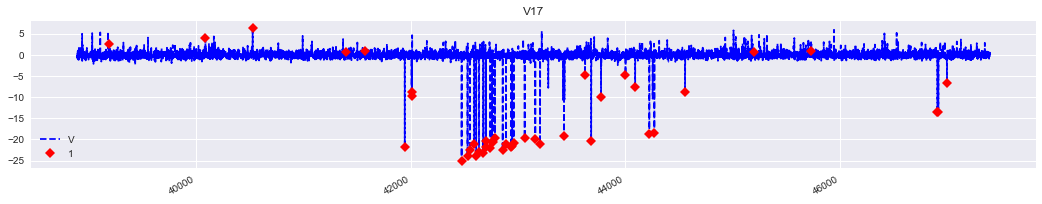

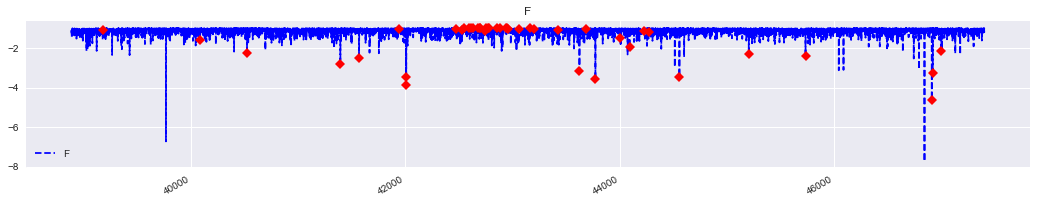

In [304]:
df_ = get_hour_df(df, 11)
df_['F'] = factor[11]
anomalies = df_[df_["Class"]==1]

columns=['V17', 'F']
for col in columns:
    plt.style.use('seaborn')
    plt.figure(figsize=(18,3))
    plt.plot(df_[col], color='blue',linestyle='--', zorder=1)
    plt.plot(anomalies[col], linestyle='none', marker='D', color='red',zorder=2)
    plt.gcf().autofmt_xdate()
    plt.title(col)
    plt.legend(col)
    plt.show()

In [305]:
#['V17', 'V14', 'V12', 'V10', 'V16', 'V11', 'V18']
def get_hour_data_2(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    _["Amount"] = _["Amount"]
    _["Time"] = _["Time"]
    _["V17"] = _["V17"]
    X = _[['V17','V14', 'V12', 'V10', 'V16', 'V11', 'V18','Time']].to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

In [306]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor = []
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=20, 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=m_rate[i]*5)
    X, y = get_hour_data_2(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor.append(clf.negative_outlier_factor_)
    
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[143422   1042]
 [    86    195]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    143508
         1.0       0.69      0.16      0.26      1237

    accuracy                           0.99    144745
   macro avg       0.84      0.58      0.63    144745
weighted avg       0.99      0.99      0.99    144745



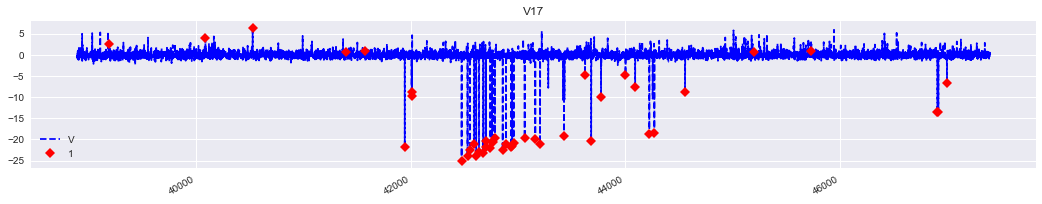

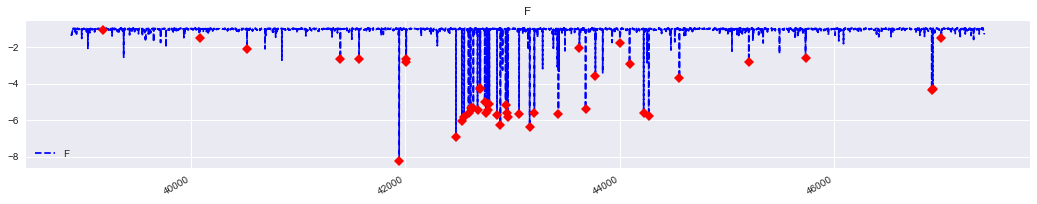

In [307]:
df_ = get_hour_df(df, 11)
df_['F'] = factor[11]
anomalies = df_[df_["Class"]==1]

columns=['V17', 'F']
for col in columns:
    plt.style.use('seaborn')
    plt.figure(figsize=(18,3))
    plt.plot(df_[col], color='blue',linestyle='--', zorder=1)
    plt.plot(anomalies[col], linestyle='none', marker='D', color='red',zorder=2)
    plt.gcf().autofmt_xdate()
    plt.title(col)
    plt.legend(col)
    plt.show()

We can see that F factor doesn't have good marginal seperation, this may suggest the problem of marginal point, which can be caused by number of neighbor in calculation. So I tried to lower neighbor number

In [308]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor = []
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=10, 
                             algorithm='kd_tree', 
                             leaf_size=25, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=m_rate[i]*5)
    X, y = get_hour_data_2(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor.append(clf.negative_outlier_factor_)
    
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[143444   1020]
 [    64    217]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    143508
         1.0       0.77      0.18      0.29      1237

    accuracy                           0.99    144745
   macro avg       0.88      0.59      0.64    144745
weighted avg       0.99      0.99      0.99    144745



The Precision now is pretty good!

In [309]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor = []
for i in range(48):
    clf = LocalOutlierFactor(n_neighbors=10, 
                             algorithm='kd_tree', 
                             leaf_size=25, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=0.004)
    X, y = get_hour_data_2(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor.append(clf.negative_outlier_factor_)
    
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[283337    909]
 [   237    255]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    283574
         1.0       0.52      0.22      0.31      1164

    accuracy                           1.00    284738
   macro avg       0.76      0.61      0.65    284738
weighted avg       0.99      1.00      1.00    284738



## Scanning Smaller Time Window

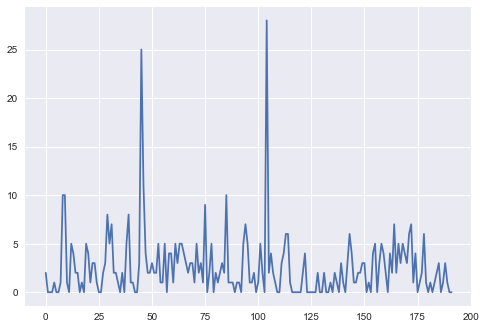

In [310]:
def get_hour_anomaly2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    anomalies = _[_["Class"]==1]
    return anomalies.shape[0]
anomaly2 = []
for i in range(48*4):
    anomaly2.append(get_hour_anomaly2(df, i))
plt.plot(anomaly2)

In [311]:
def get_hour_rate2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    anomalies = _[_["Class"]==1]
    con_rate = anomalies.shape[0]/_.shape[0]
    return con_rate

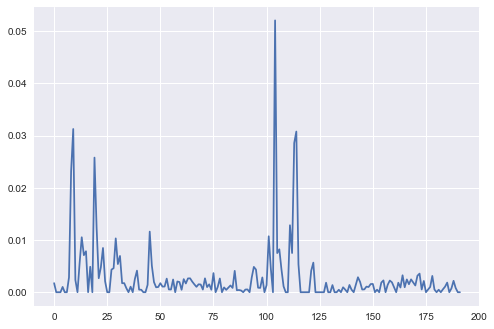

In [312]:
rate2 = []
for i in range(48*4):
    rate2.append(get_hour_rate2(df, i))
plt.plot(rate2)

In [313]:
#['V17', 'V14', 'V12', 'V10', 'V16', 'V11', 'V18']
def get_hour_data2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    #_["Amount"] = _["Amount"]/40
    _["Time"] = _["Time"]
    _["V17"] = _["V17"]
    X = _[['V17','V14', 'V12', 'V10', 'V16', 'V11', 'V18', 'Time']].to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

In [324]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor2 = []
for i in range(48*4):
    clf = LocalOutlierFactor(n_neighbors=10, 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination= rate2[i]*2+0.00001)
    X, y = get_hour_data2(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor2.append(clf.negative_outlier_factor_)
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[283193    829]
 [   178    314]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    283371
         1.0       0.64      0.27      0.38      1143

    accuracy                           1.00    284514
   macro avg       0.82      0.64      0.69    284514
weighted avg       1.00      1.00      1.00    284514



However the 15 min rate is unjustifiable in this experiment.

Proposal: Use Change point detection to detect time window for better rate

## Local Outlier Factor Analysis

In [325]:
def get_hour_df2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    return _

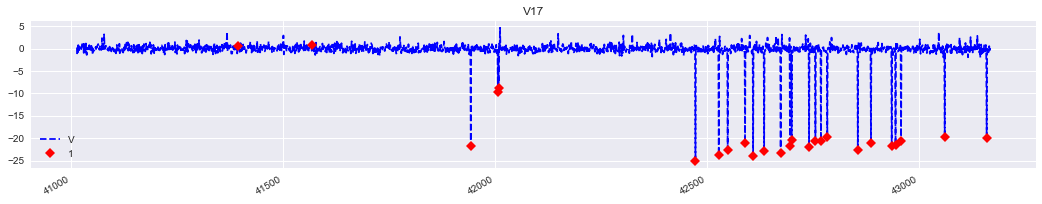

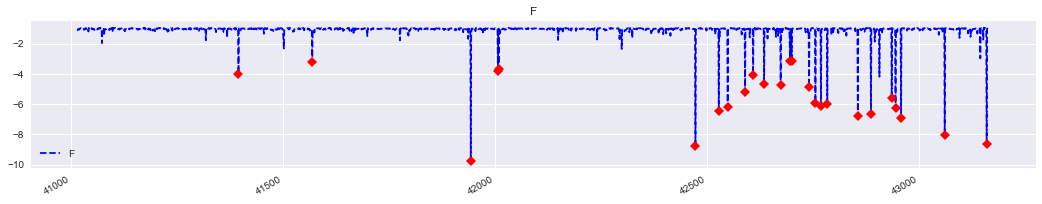

In [326]:
df_ = get_hour_df2(df, 45)
df_['F'] = factor2[45]
anomalies = df_[df_["Class"]==1]

columns=['V17', 'F']
for col in columns:
    plt.style.use('seaborn')
    plt.figure(figsize=(18,3))
    plt.plot(df_[col], color='blue',linestyle='--', zorder=1)
    plt.plot(anomalies[col], linestyle='none', marker='D', color='red',zorder=2)
    plt.gcf().autofmt_xdate()
    plt.title(col)
    plt.legend(col)
    plt.show()

In this example F factor detect 2 points that Heuristic cut doesn't catch on